In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%reload_ext autoreload
%autoreload 2

# <span style='color:lightgreen'>Logs

In [3]:
model_id = 'USC_32_32'
input_features = 'P'
lt_logs_df = pd.read_csv('./logs/long_term_forecast.csv', index_col = 0)
query = (lt_logs_df['model_id'] == model_id)&(lt_logs_df['input_features'] == input_features)&(lt_logs_df['inverse'])
lt_logs_df[query][['model', 'data', 'input_features','seq_len', 'pred_len', 'lstm_layers', 'e_layers','d_model', 'd_layers',
       'dropout', 'learning_rate', 'nb_params', 'rmse','mse', 'mae']]

,model,data,input_features,seq_len,pred_len,lstm_layers,e_layers,d_model,d_layers,dropout,learning_rate,nb_params,rmse,mse,mae
64,iTransformer,USC,P,32,32,1,2,64,1,0.1,0.001,566624,0.049990,0.002499,0.035285
65,TimeMixer,USC,P,32,32,1,2,64,1,0.1,0.001,860417,0.071279,0.005081,0.046325
66,Nonstationary_Transformer,USC,P,32,32,1,2,64,1,0.1,0.001,1578656,0.738036,0.544698,0.417810
67,ADAPT,USC,P,32,32,1,2,64,1,0.1,0.001,350320,13.198420,174.198273,9.322182
68,iTransformer,USC,P,32,32,1,2,64,1,0.1,0.001,566624,0.027946,0.000781,0.019039
69,PatchTST,USC,P,32,32,1,2,64,1,0.1,0.001,891809,0.128472,0.016505,0.079522


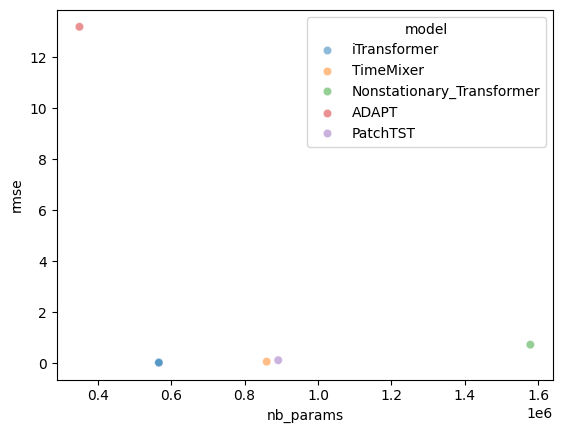

In [4]:
sns.scatterplot( data = lt_logs_df[query], 
                x = 'nb_params', y='rmse', hue= 'model', alpha = 0.5);

In [5]:
st_logs_df = pd.read_csv('./logs/short_term_forecast.csv', index_col = 0)
st_logs_df[['model', 'seasonal_patterns','data', 'seq_len', 'pred_len', 'c_out', 'd_model', 'n_heads', 'e_layers', 'd_layers', 'd_ff',
       'moving_avg', 'dropout', 'learning_rate', 'avg_smape', 'avg_mase', 'avg_owa', 'avg_mape']]

,model,seasonal_patterns,data,seq_len,pred_len,c_out,d_model,n_heads,e_layers,d_layers,d_ff,moving_avg,dropout,learning_rate,avg_smape,avg_mase,avg_owa,avg_mape
0,LSTransformer,Monthly,m4,36,18,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
1,LSTransformer,Yearly,m4,12,6,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
2,LSTransformer,Quarterly,m4,16,8,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
3,LSTransformer,Weekly,m4,26,13,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
4,LSTransformer,Daily,m4,28,14,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
5,LSTransformer,Hourly,m4,96,48,1,128,16,1,1,2048,25,0.25,0.001,85.159,18.813,8.059,66.652
6,TimesNet,Hourly,m4,96,48,1,32,8,2,1,32,25,0.10,0.001,11.920,1.598,0.857,14.017
7,Nonstationary_Transformer,Hourly,m4,96,48,1,512,8,2,1,2048,25,0.10,0.001,NaN,NaN,NaN,NaN


# <span style = 'color:lightblue'> Model

In [ ]:
from types import SimpleNamespace
configs = SimpleNamespace(**lt_logs_df.loc[21].to_dict())
configs.model

'LSTransformer'

In [ ]:
from models.LSTransformer import Model
from utils.model_wrapper import ModelWrapper
model = ModelWrapper(Model(configs=configs), configs)
model.summary()

Model quick summary
Layer name                    |          Nb units|      Nb tr params|  Nb non tr params
LSTM_0                        |               256|           271 360|                 0
Linear_0                      |               256|             2 048|                 0
LayerNorm_0                   |                 -|               512|                 0
Linear_1                      |               128|            32 896|                 0
TransformerEncoderLayer_0     |               128|           593 024|                 0
Linear_2                      |               256|            33 024|                 0
LayerNorm_1                   |                 -|               512|                 0
Linear_3                      |               336|            86 352|                 0
Skip_connections : True
Transformer_nb_heads : 8
Transformer_FF_units : 2048
Dropout_rate : p = 0.5

Nb trainable parameters : 1 019 728
Nb non-trainable parameters : 0
Total nb parameters